In [1]:
# settings 
# img_size is dimension to resize images to.
img_size = (175,175)
# number of pics in each class to use. use None for all
pics_per_class = 75
#pics_per_class = None
# set zipped datafile location​img_size
data_file = '~/kaggle/competitions/plant-seedlings-classification/train.zip'


# H2O server settings
# h2o_server = 'localhost'
h2o_server = 'nkpc'
h2o_port = 54321
max_mem_gb = 14
min_mem_gb = 4

# imports
import h2o
import os
import zipfile
import pandas as pd
import numpy as np
import cv2
from scipy import stats
import matplotlib.pyplot as plt
import itertools
import re
import seaborn as sns
from ds_functions import *

from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator


def h2oinit():
    h2o.init(ip=h2o_server, port=h2o_port, 
         max_mem_size_GB=max_mem_gb, min_mem_size_GB=min_mem_gb)
    
def perf_to_cm_array(perf):
    """Takes an h2o model performance object and returns a numpy array
    with the confusion matrix)"""
    cm_df = perf.confusion_matrix().as_data_frame()
    n_classes = len(cm_df) - 1
    return np.array(cm_df.iloc[:n_classes, :n_classes])

In [2]:
h2oinit()

Checking whether there is an H2O instance running at http://nkpc:54321. connected.


H2O cluster uptime:,3 mins 41 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.8
H2O cluster version age:,1 day
H2O cluster name:,Nick
H2O cluster total nodes:,1
H2O cluster free memory:,12.43 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [3]:
def images_to_df(filepath, img_size=(200, 200), pics_per_class=None):
    """Extracts images from data file and converts each into an H2O dataframe row. 
    Outputs a pandas dataframe"""
    cols = ['px' + str(i) for i in range(1,1 + 3 * img_size[0] * img_size[1])]
    cols = ['class', 'id'] + cols
    # set column names
    
    ret_df = pd.DataFrame()

    # extrac the images through each folder. 
    if not os.path.isdir('./train'):
        zfile = zipfile.ZipFile(filepath)
        zfile.extractall()

    for dname in os.listdir('./train'):
        if os.path.isdir('./train/' + dname):
            for fname in os.listdir('./train/' + dname)[0:pics_per_class]:
                cl = dname
                ix = fname[:-4]
                im = cv2.imread('./train/' + dname + '/' + fname)
                
                # to put into an DataFrame for classification, 
                # all the images need to be the same dimension. 
                im = cv2.resize(im, (img_size[0],img_size[1])).reshape(-1)
                im = im.reshape(1, len(im))
                df = pd.DataFrame({
                    'class':[cl],
                    'id':[ix]
                })
                df = df.join(pd.DataFrame(im))
                ret_df = pd.concat([ret_df, df])
    ret_df.columns = cols
    return ret_df.reset_index(drop=True)

In [4]:
# load the data
data = images_to_df(data_file, 
                    img_size=img_size,
                    pics_per_class=pics_per_class)


In [5]:
# notice that in the pictures, the green part is the plant. maybe try enhancing the weight for green columns
# each row is a 500 X 500 with 3 color values, for a total of 750,000 pixels. 
# thus the greens are going to be one the sets of 250,000 pixels. Figure out which one.

# try plotting the data. See what color is the most common
colrange = {}
for i in range(1,4):
    colrange[i] = ['px' + str(j) for j in range(1 + (i-1), img_size[0] * img_size[1], 3)]
    
color_sums = pd.DataFrame({
    'id': data.loc[:, 'id']
})

for i in range(1,4):
    color_sums['color_sum' + str(i)] = data.loc[:, colrange[i]].sum(axis=1).reset_index(drop=True)
    # also add the average
    color_sums['color_mean' + str(i)] = data.loc[:, colrange[i]].mean(axis=1).reset_index(drop=True)
    

# each row in the resulting dataframe represents an image, and the columns are the sum of the
# pixel values for that color range. Assuming that's how it works.
color_sums.head(50)

# just looking at the head, it does appear color3 dominates. Could that be green?
# Let's take a closer look

,id,color_sum1,color_mean1,color_sum2,color_mean2,color_sum3,color_mean3
0,0050f38b3,421429,41.284189,577283,56.552018,749228,73.396160
1,0183fdf68,501385,49.116869,699068,68.482367,884109,86.609424
2,0260cffa8,785898,76.988440,863456,84.586207,940659,92.149197
3,05eedce4d,478297,46.855114,671417,65.773609,848831,83.153507
4,075d004bc,913857,89.523609,924615,90.577488,952355,93.294965
5,078eae073,500763,49.055937,696933,68.273217,882055,86.408209
6,082314602,467644,45.811520,635990,62.303096,823731,80.694651
7,0ace21089,1117421,109.465223,1152060,112.858542,1207225,118.262637
8,0b228a6b8,669043,65.541046,815705,79.908405,944446,92.520180
9,0b3e7a7a9,786234,77.021356,821405,80.466791,878829,86.092183


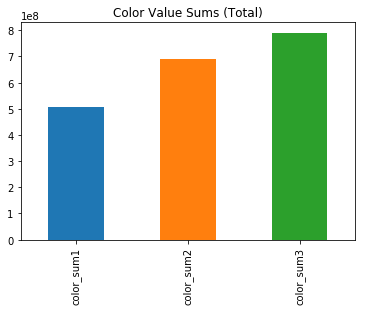

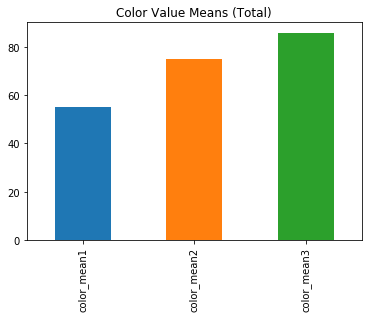

In [6]:
color_sums.iloc[:, [1,3,5]].sum().plot(kind='bar', title='Color Value Sums (Total)')
plt.show()

color_sums.iloc[:, [2,4,6]].mean().plot(kind='bar', title='Color Value Means (Total)')
plt.show()


# well, I see that color 3 is the most represented. Doesn't necessarily mean that's green
# many of the pictures have lots of gravel which is more reddish. I'm guessing the 
# color order is Blue - Red - Green, which matches the plot but that's just a coincidence

# i need to look up the documentation for OpenCV


#####
# next look for an association between color distribution and class 
# do additional EDA

In [7]:
# I'll try joining the total color data to the pixel data and include the sum of each color as a feature
if not 'color_sum1' in list(data.columns):
    data = data.merge(color_sums, on='id')

data.head()

,class,id,px1,px2,px3,px4,px5,px6,px7,px8,...,px91872,px91873,px91874,px91875,color_sum1,color_mean1,color_sum2,color_mean2,color_sum3,color_mean3
0,Black-grass,0050f38b3,26,49,79,21,45,74,39,60,...,72,61,55,59,421429,41.284189,577283,56.552018,749228,73.396160
1,Black-grass,0183fdf68,40,46,55,42,48,57,45,50,...,97,55,73,93,501385,49.116869,699068,68.482367,884109,86.609424
2,Black-grass,0260cffa8,20,29,48,22,32,43,20,27,...,109,107,106,109,785898,76.988440,863456,84.586207,940659,92.149197
3,Black-grass,05eedce4d,51,84,108,53,86,110,55,89,...,95,72,83,98,478297,46.855114,671417,65.773609,848831,83.153507
4,Black-grass,075d004bc,167,163,165,165,163,162,164,164,...,58,26,41,56,913857,89.523609,924615,90.577488,952355,93.294965


In [8]:
# this isn't much to work with, but let's see if I can run it through h2o
features = ['px' + str(i) for i in range(1,1 + 3 * img_size[0] * img_size[1])] 
features += ['color_sum'+str(i) for i in range(1,4)]
features += ['color_mean'+str(i) for i in range(1,4)]

target = 'class'

h2oinit()

h2o_data = h2o.H2OFrame(python_obj=data.drop('id', axis=1))


Checking whether there is an H2O instance running at http://nkpc:54321. connected.


H2O cluster uptime:,4 mins 31 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.8
H2O cluster version age:,1 day
H2O cluster name:,Nick
H2O cluster total nodes:,1
H2O cluster free memory:,12.43 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [9]:
# create train/test set.
h2o_train, h2o_test = h2o_data.split_frame(ratios=[0.90])


In [10]:
rf = H2ORandomForestEstimator()

rf.train(x=features, y=target, training_frame=h2o_train)

drf Model Build progress: |███████████████████████████████████████████████

H2OConnectionError: Unexpected HTTP error: HTTPConnectionPool(host='nkpc', port=54321): Max retries exceeded with url: /3/Jobs/$03010a0000da32d4ffffffff$_88d8488b56269ecf99dc8354d1574d5c (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000040757CD2B0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it',))

In [ ]:
rf_perf = rf.model_performance(test_data=h2o_test)

rf_perf.show()

In [ ]:
dl = H2ODeepLearningEstimator()

# Suggestions:
# Limit the size of the first hidden layer
dl.train(x=features, y=target, training_frame=h2o_train)

In [ ]:
dl_perf = dl.model_performance(test_frame=h2o_test)
dl_perf.show()